In [ ]:
!pip install gensim textblob

In [ ]:
import pandas as pd
import nltk
import gensim
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#pre-processing reviews
def tokenize_text(text):
    text = str(text).lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens
                  if token.isalpha() and token not in stop_words]
    return lemmatized

def join_tokens(text):
    return ' '.join(text)

#lexicon based sentiment analysis
def sentiment_analysis(df,col_name):
    df_textblob = pd.DataFrame()
    df_vader = pd.DataFrame()

    df_textblob['index'] = df['index']  # Retain original index
    df_vader['index'] = df['index']

    # TextBlob sentiment
    df_textblob['sentiment_score'] = df[col_name].apply(lambda x: TextBlob(x).sentiment.polarity)
    df_textblob['sentiment_label'] = df_textblob['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.4 else 'negative' if x < -0.4 else 'neutral')

    # VADER sentiment
    df_vader['sentiment_score'] = df[col_name].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df_vader['sentiment_label'] = df_vader['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.04 else 'negative' if x < -0.04 else 'neutral')

    # Merge on original index and sentiment_label
    merged_df = pd.merge(df_textblob, df_vader, on=['index', 'sentiment_label'], how='inner')
    merged_df = merged_df.set_index('index')  # Restore original index

    # Filter original df based on index
    filtered_df = df.set_index('index').loc[merged_df.index].copy()
    filtered_df['sentiment_label'] = merged_df['sentiment_label']
    filtered_df['TB_SCORE'] = merged_df['sentiment_score_x']
    filtered_df['VADER_SCORE'] = merged_df['sentiment_score_y']

    return filtered_df


In [ ]:
from itertools import count
#aspect based sentiment analysis
def aspect_sentiment_analysis(df, aspects, col_name):
    results = []

    for aspect in aspects:
        # Find reviews mentioning the aspect
        aspect_reviews = df[df[col_name].str.contains(aspect, case=False, regex=True)]

        if len(aspect_reviews) > 0:
            # Calculate sentiment for these reviews
            output= sentiment_analysis(aspect_reviews,col_name)
            sentiments = output['sentiment_label']
            pred_txb = output['TB_SCORE']
            pred_vader = output['VADER_SCORE']

            # Map sentiment labels to numeric scores
            sentiment_numeric = sentiments.map({'positive': 1, 'neutral': 0, 'negative': -1})

            # Aggregate results
            stats = {
                'aspect': aspect,
                'mention_count': len(aspect_reviews),
                'avg_pred_sentiment': sentiment_numeric.mean()*100,
                #'avg_snt_txb': pred_txb.mean() * 100,
                #'avg_snt_vader': pred_vader.mean() * 100,
                'positive_pct': (sentiments == 'positive').mean() * 100,
                'negative_pct': (sentiments == 'negative').mean() * 100,
                'neutral_pct': (sentiments == 'neutral').mean() * 100
            }
            results.append(stats)

    aspect_results=pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='aspect', y='avg_pred_sentiment', data=aspect_results.sort_values('avg_pred_sentiment'))
    return print(aspect_results)

In [ ]:
# n-gram analysis
def n_gram(df,col_name,n_token,words_to_remove):
  df_ngram=pd.DataFrame()
  df_ngram['processed_text'] = df[col_name].apply(tokenize_text).apply(join_tokens)

  stop_words = set(stopwords.words('english')).union(set(words_to_remove))

  vectorizer = CountVectorizer(
    stop_words=list(stop_words) ,
    token_pattern=r'(?u)\b\w\w+\b',
    ngram_range=(n_token,n_token),
    max_df=0.99,
    min_df=2
  )
  X = vectorizer.fit_transform(df_ngram['processed_text'])

  ngrams = vectorizer.get_feature_names_out()
  ngrams_freq = pd.DataFrame(X.toarray(), columns=ngrams).sum().sort_values(ascending=False)
  top_ngrams = ngrams_freq.head(20)

  # Post-processing to filter similar n-grams
  unique_ngrams = []
  seen_lemmas = set()

  for ngrams in top_ngrams.index:
      # Get unique lemmas
      ngrams_lemmas = frozenset([lemmatizer.lemmatize(word) for word in ngrams.split()])

      # Only keep if we haven't seen this combination before
      if ngrams_lemmas not in seen_lemmas:
          unique_ngrams.append(ngrams)
          seen_lemmas.add(ngrams_lemmas)
      if len(unique_ngrams) >= 10:
          break

  final_ngrams = top_ngrams[unique_ngrams]

  # Visualization
  plt.figure(figsize=(12, 8))
  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')
  plt.xlabel("Frequency")
  return print(final_ngrams)


In [ ]:
#aspect based clustering
def clustering_review(df,col_name,n_clusters,aspects):
  aspect_sentences = {}
  for aspect in aspects:
    subset = df[df[col_name].str.contains(aspect, case=False, na=False)]
    aspect_sentences[aspect] = [tokenize_text(text) for text in subset[col_name]]


  for aspect, sentences in aspect_sentences.items():
    print(f"\n=== Aspect: {aspect} ===")
    if len(sentences) < 5:
        print("Not enough data.")
        continue

    model = Word2Vec(sentences, vector_size=100, window=5, min_count=100, workers=4)

    words = list(model.wv.index_to_key)
    vectors = np.array([model.wv[word] for word in words])

    if len(words) < 5:
        print("Not enough unique words to cluster.")
        continue

    n = min(n_clusters, len(words))  # avoid asking for more clusters than words
    kmeans = KMeans(n_clusters=n, random_state=0)
    clusters = kmeans.fit_predict(vectors)
    centroids = kmeans.cluster_centers_

    word_df = pd.DataFrame(vectors, index=words)
    word_df['cluster'] = clusters

    top_words = {}
    for i in range(n_clusters):
        cluster_words = word_df[word_df['cluster'] == i].drop('cluster', axis=1)
        dists = np.linalg.norm(cluster_words.values - centroids[i], axis=1)
        closest_indices = dists.argsort()[:5]
        top_words[i] = cluster_words.iloc[closest_indices].index.tolist()

    for cluster_id, words in top_words.items():
        print(f"Cluster {cluster_id}: {words}")


In [ ]:
def generate_aspect_wordclouds(df, aspects, col_name):
    for aspect in aspects:
        # Filter reviews containing the aspect
        aspect_reviews = df[df[col_name].str.contains(aspect, case=False, regex=True)]

        if not aspect_reviews.empty:
            # Apply tokenize_text to each review, then flatten the list of tokens
            all_tokens = []
            for review in aspect_reviews[col_name].dropna().astype(str):
                tokens = tokenize_text(review)
                all_tokens.extend(tokens)

            # Join tokens into a single string
            text = " ".join(all_tokens)

            # Generate word cloud
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

            # Display
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud for Aspect: '{aspect}'", fontsize=16)
            plt.show()


In [ ]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def analyze_reviews(df, text_column, aspects):
    """
    Find most relevant words around your aspects WITHOUT clustering

    Args:
        df: Your DataFrame
        text_column: Name of text column
        aspects: List of focus words (e.g., ['price', 'quality'])

    Returns:
        Dictionary of {aspect: [top 10 related words]}
    """
    results = {}
    stop_words = set(stopwords.words('english'))

    for aspect in aspects:
        aspect_words = []

        for text in df[text_column].dropna().str.lower():
            words = nltk.word_tokenize(text)

            if aspect in words:
                idx = words.index(aspect)
                start = max(0, idx-5)  # 3 words before
                end = min(len(words), idx+4)  # 3 words after
                context = words[start:end]

                # Filter out junk
                clean_words = [
                    w for w in context
                    if w not in stop_words
                    and w.isalpha()
                    and w != aspect
                ]
                aspect_words.extend(clean_words)

        # Get most common words
        top_words = [word for word, count in Counter(aspect_words).most_common(10)]
        results[aspect] = top_words

    return results


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_review = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Appliances.jsonl", lines=True)
df_product = pd.read_json("meta_Appliances.jsonl", lines=True)

In [ ]:
abc=df_product[(df_product['rating_number']>5000) & (df_product['main_category']=='Appliances')]
abc.to_csv('abc.csv')

In [ ]:
abc=df_product[df_product['parent_asin']=='B0C5YSMG64']
print(abc.features.values)
selected_product=df_review[df_review['parent_asin']=='B0C5YSMG64'].reset_index(drop=False)
sub_df=sentiment_analysis(selected_product,'text')
sub_df.to_csv('d1.csv')
pos_df=sub_df[sub_df['sentiment_label']=='positive']
neg_df=sub_df[sub_df['sentiment_label']=='negative']
neu_df=sub_df[sub_df['sentiment_label']=='neutral']

[list(['30-INCH UNDER-CABINET RANGE HOOD INSERT: Fits neatly underneath cabinets to offer a complete solution to your kitchen ventilation needs by providing both an exhaust fan and overhead light', 'IMPROVES KITCHEN AIR QUALITY: Provides a MAX 230 CFM and 6.5 Sones performance to quickly remove smoke and cooking odors from the air, and the 2-speed rocker switch allows for quick fan adjustments', '4-WAY CONVERTIBLE INSTALLATION: Installs as 3.25" x 10" vertical or horizontal ducting with damper, 7" round vertical ducting (damper sold separately), or non-ducted with air recirculation (filter sold separately) to provide versatile installation at least 18" above the cooktop'])]


In [ ]:
df_product['main_category'].unique()
neg_df

In [ ]:
n_gram(pos_df,'text',2,['would'])

In [ ]:
aspect_sentiment_analysis(selected_product,['install','look','price','size'],'text')

In [ ]:
def aspect_based_sentiment_analysis(df, aspects=None, col_name='text', use_lexicon=False):
    results = []
    aspect_mapping = {}
    ASPECT_LEX = {
    "length": ["length", "long", "short", "little", "tall", "compact"],
    "width": ["width", "wide", "narrow", "broad", "slim"],
    "install": ["install", "easy", "difficult","complex","simple"],
    "weight": ["weight", "heavy", "light", "bulky"],
    "price": ["price", "money", "affordable", "expensive","cheap","costly","overpriced"],
    }
    # Handle aspect sources
    if use_lexicon and aspects:
        # Case 1: Both lexicon and specific aspects requested (merge them)
        all_aspects = list(aspects)  # Start with provided aspects
        for main_aspect, synonyms in ASPECT_LEX.items():
            all_aspects.extend(synonyms)
            aspect_mapping.update({syn: main_aspect for syn in synonyms})
        # Map provided aspects to themselves unless in lexicon
        aspect_mapping.update({a: a for a in aspects if a not in aspect_mapping})
    elif use_lexicon:
        # Case 2: Only use lexicon
        all_aspects = []
        for main_aspect, synonyms in ASPECT_LEX.items():
            all_aspects.extend(synonyms)
            aspect_mapping.update({syn: main_aspect for syn in synonyms})
    else:
        # Case 3: Only use provided aspects
        all_aspects = aspects if aspects else []
        aspect_mapping = {a: a for a in all_aspects}  # Map to self

    if not all_aspects:
        print("No aspects specified and lexicon not used.")
        return pd.DataFrame()

    # Analysis loop
    for aspect in all_aspects:
        pattern = r'\b(?:{})\b'.format(re.escape(aspect))  # Safer regex
        aspect_reviews = df[df[col_name].str.contains(pattern, case=False, regex=True, na=False)]

        if len(aspect_reviews) > 0:
            output = sentiment_analysis(aspect_reviews, col_name)
            sentiments = output['sentiment_label']
            sentiment_numeric = sentiments.map({'positive': 1, 'neutral': 0, 'negative': -1}).dropna()

            if not sentiment_numeric.empty:
                stats = {
                    'aspect_term': aspect,
                    'main_aspect': aspect_mapping[aspect],
                    'mention_count': len(aspect_reviews),
                    'avg_pred_sentiment': sentiment_numeric.mean() * 100,
                    'positive_pct': (sentiments == 'positive').mean() * 100,
                    'negative_pct': (sentiments == 'negative').mean() * 100,
                    'neutral_pct': (sentiments == 'neutral').mean() * 100
                }
                results.append(stats)

    # Post-processing
    if not results:
        print("No reviews matched the specified aspects.")
        return pd.DataFrame()

    aspect_results = pd.DataFrame(results)
    final_results = aspect_results.groupby('main_aspect').agg({
        'mention_count': 'sum',
        'avg_pred_sentiment': 'mean',
        'positive_pct': 'mean',
        'negative_pct': 'mean',
        'neutral_pct': 'mean'
    }).reset_index()

    # Visualization
    if not final_results.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x='main_aspect',
            y='avg_pred_sentiment',
            data=final_results.sort_values('avg_pred_sentiment', ascending=False)
        )
        plt.title('Aspect-Based Sentiment Analysis')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return final_results

/tmp/ipython-input-3520228773.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


fit perfectly      21
stainless steel    15
fast shipping      12
price install      12
exhaust fan         8
old one             8
price right         7
noise level         7
install fit         6
arrived quickly     5
dtype: int64


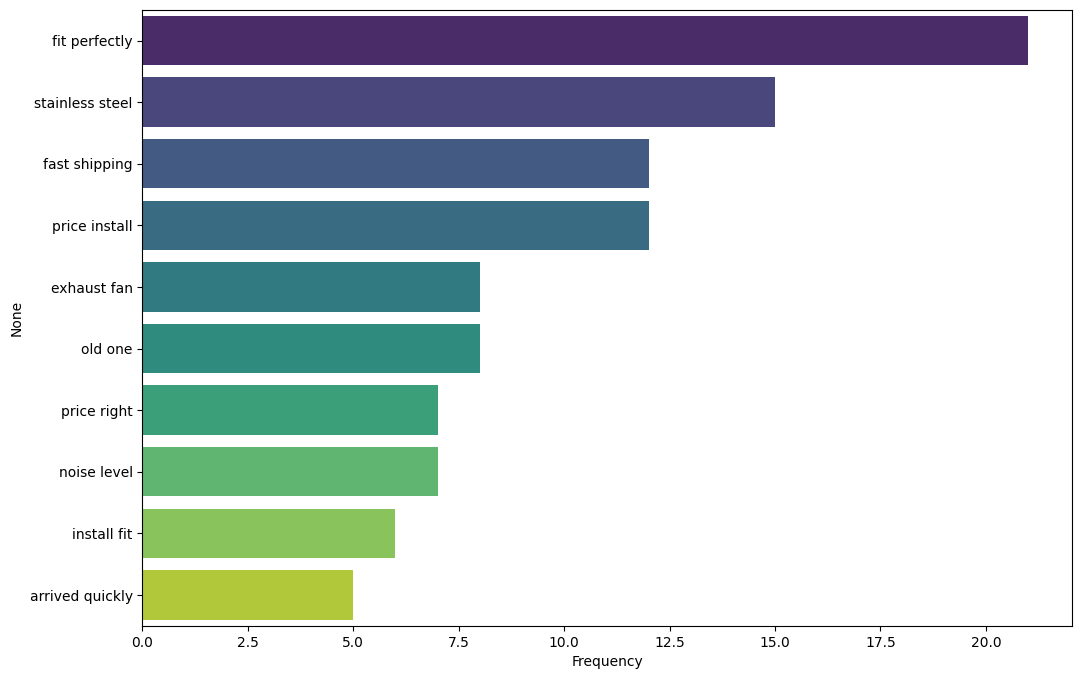

In [ ]:
n_gram(pos_df,'text',2,['happy','look','purchase','recommend','love','easy','work','product','well',
                        'nice','great','hood','good','perfect','would'])

/tmp/ipython-input-3520228773.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


box        3
dent       3
dented     3
hood       3
install    3
damage     2
damaged    2
fan        2
return     2
work       2
dtype: int64


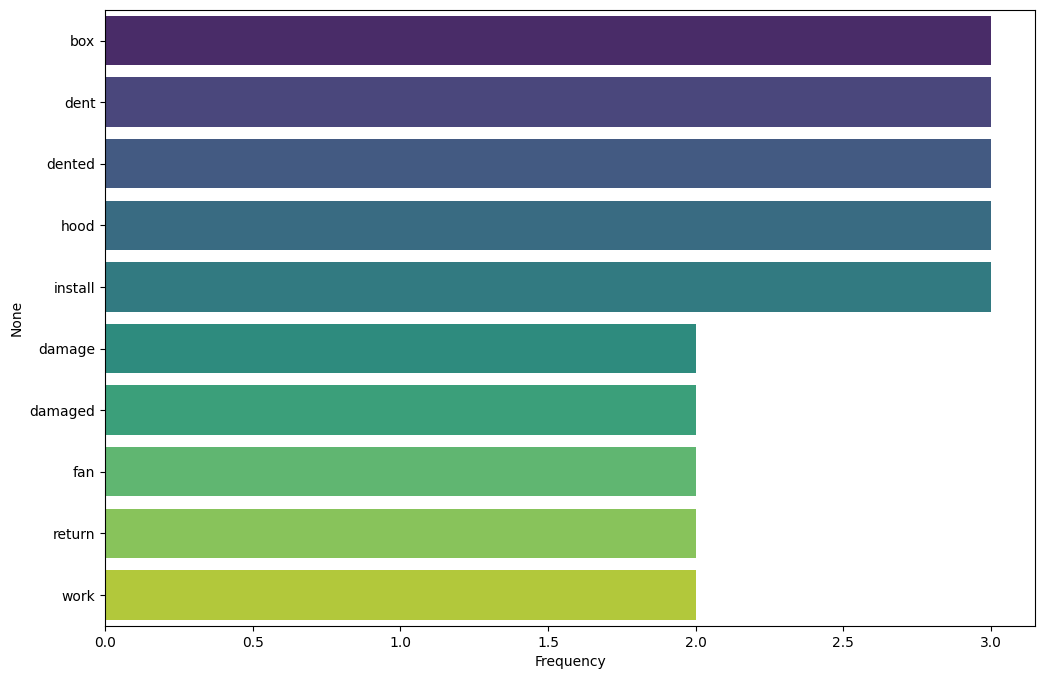

In [ ]:
n_gram(neg_df,'text',1,['bad','disappointed','product','came'])

/tmp/ipython-input-3520228773.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


old one            3
work expected      3
front vent         3
range hood         3
muy bueno          3
came bent          2
vent cover         2
stainless steel    2
scale gave         2
quaility scale     2
dtype: int64


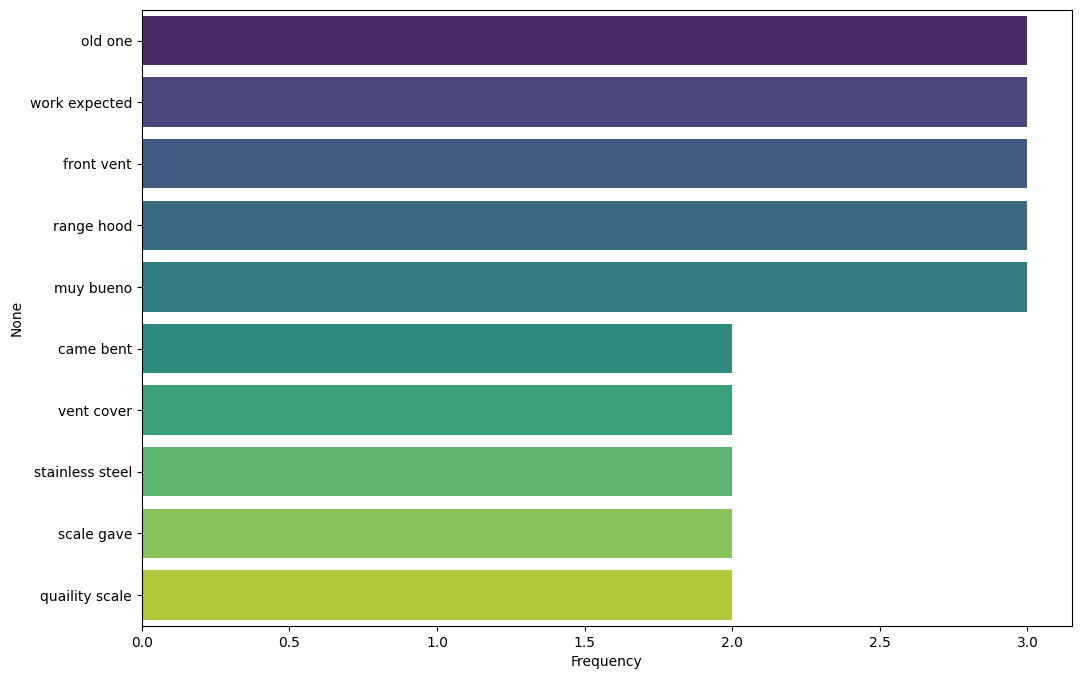

In [ ]:
n_gram(neu_df,'text',2,['product'])

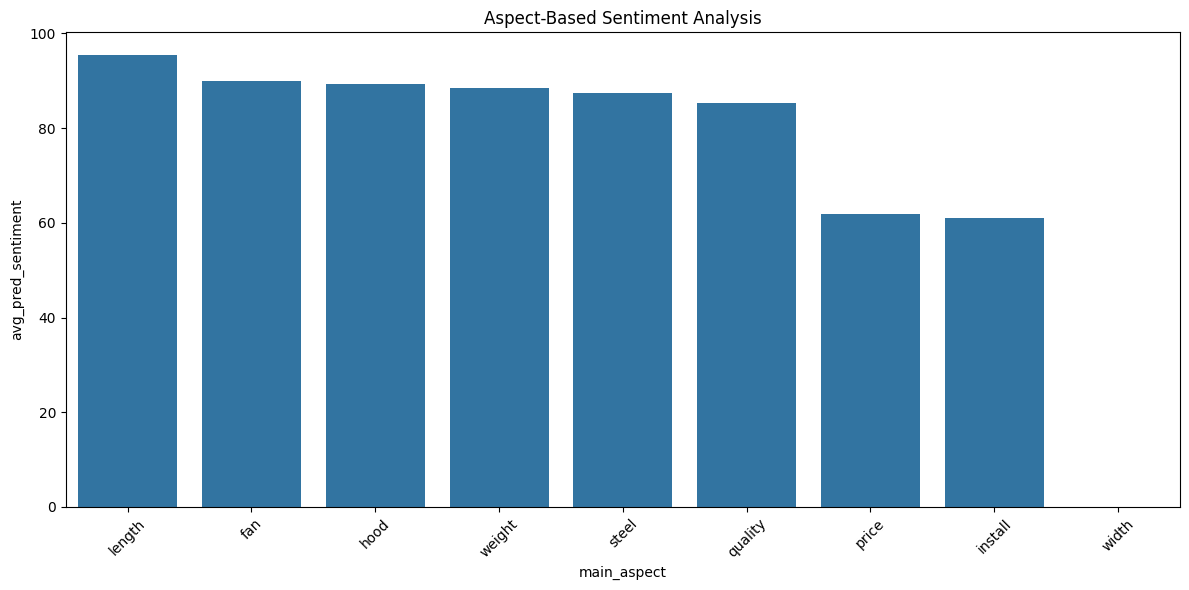

,main_aspect,mention_count,avg_pred_sentiment,positive_pct,negative_pct,neutral_pct
0,fan,307,89.855072,92.753623,2.898551,4.347826
1,hood,443,89.230769,90.769231,1.538462,7.692308
2,install,1005,60.914634,73.780488,12.865854,13.353659
3,length,128,95.454545,95.454545,0.000000,4.545455
4,price,478,61.927536,62.060870,0.133333,37.805797
5,quality,85,85.294118,88.235294,2.941176,8.823529
6,steel,71,87.500000,87.500000,0.000000,12.500000
7,weight,184,88.571429,88.571429,0.000000,11.428571
8,width,9,0.000000,0.000000,0.000000,100.000000


In [ ]:
ASPECT_LEX = {
    "length": ["length", "long", "short", "little", "tall", "compact"],
    "width": ["width", "wide", "narrow", "broad", "slim"],
    "install": ["install", "easy", "difficult","complex","simple","installation"],
    "weight": ["weight", "heavy", "light", "bulky"],
    "price": ["price", "money", "affordable", "expensive","cheap","costly","overpriced"],
    "delivery":["time","delayed","delivery","on time","shipping","late","sooner","delivered","quick"],
    }
aspect_based_sentiment_analysis(selected_product,aspects=['hood','fan','quality','steel'], col_name='text', use_lexicon=True)


In [ ]:
# Usage:
aspects = ['hood','fan','quality','steel']
word_groups = analyze_reviews(sub_df, 'text', aspects)
word_groups

{'hood': ['range',
  'great',
  'nice',
  'easy',
  'old',
  'replace',
  'good',
  'vent',
  'looks',
  'perfect'],
 'fan': ['works',
  'great',
  'exhaust',
  'good',
  'hood',
  'light',
  'well',
  'loud',
  'excellent',
  'work'],
 'quality': ['good',
  'great',
  'product',
  'nice',
  'price',
  'easy',
  'love',
  'looks',
  'install',
  'expectations'],
 'steel': ['stainless',
  'hood',
  'matches',
  'perfectly',
  'appliances',
  'new',
  'kitchen',
  'clean',
  'stove',
  'case']}

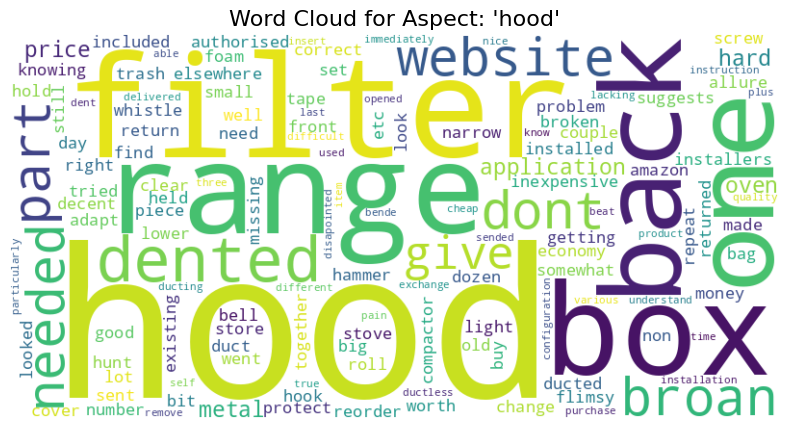

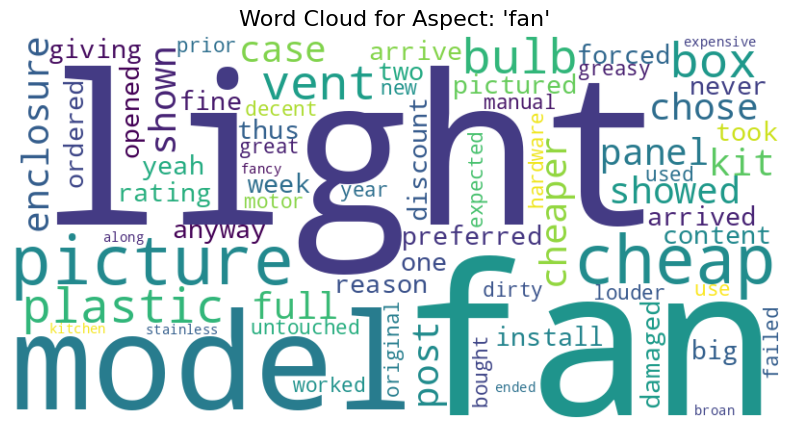

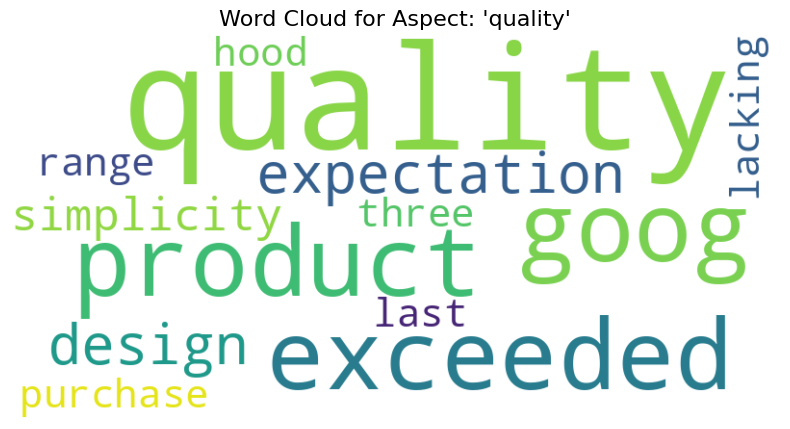

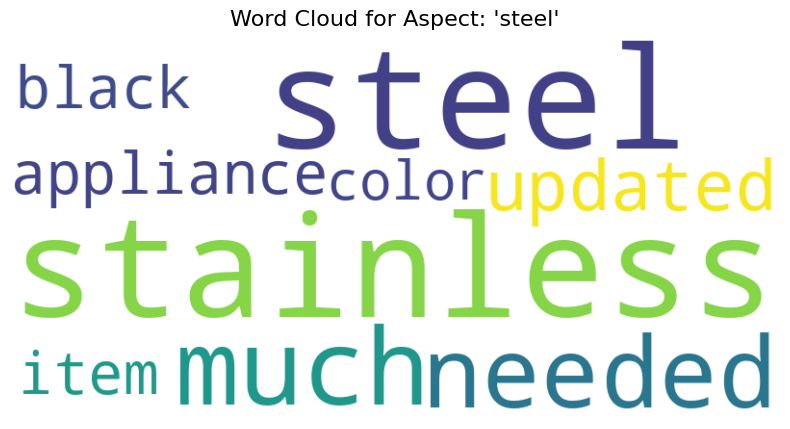

In [ ]:
aspects = ['hood','fan','quality','steel']
generate_aspect_wordclouds(neu_df,aspects,'text')